In [1]:
# Imports
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from datetime import datetime, date
from functools import partial
from multiprocessing import Pool
import matplotlib.pyplot as plt
import statistics

In [2]:
# Beolvassuk az adatokat
edgelist = pd.read_csv("../db/cosponsorship_edgelist_9th_term.csv")
epgroups = pd.read_csv("../db/epgroup_memberships_9th_term.csv")

In [3]:
# Joinoljuk az edgelist-re a documentumok keletkezési szervezetét
# Ez azért kell, hogy tudjunk szakbizottságra szűrni

# Csináljunk datetime oszlopot a "date"-ből
edgelist["date"] = pd.to_datetime(edgelist["date"])

# Hátha van benne véletlen az előző ciklusból..kidobjuk ha lenne
edgelist = edgelist[edgelist["date"]>=datetime(2019,7,1)]

# Kivesszük az évet és a hónapot külön oszlopokba
edgelist["year"] = edgelist["date"].dt.year
edgelist["month"] = edgelist["date"].dt.month

# Hasonlóan konvertáljuk a tagságokat leíró táblában is a date stringeket datetime-ba
epgroups["start_date"] = pd.to_datetime(epgroups["start_date"])
# Ha az end_date üres, az azt jelenti, hogy a lekérdezés pillanatában még érvényben volt a tagság
# Beírjuk az aktuális dátumot a helyére. Ez azért kell, hogy tudjunk összehasonlítani (<,>)
epgroups["end_date"] = pd.to_datetime(epgroups["end_date"]).fillna(datetime.now())
# Sorba rendezzük
epgroups = epgroups.sort_values(by="start_date")

print(epgroups.columns)

# Betesszük a képviselők nevét indexbe, hogy tudjunk können joinolni
epgroups = epgroups.set_index("person_full_name")

# Rájoinoljuk a tagságokat az éles táblára
edgelist_big = edgelist.join(epgroups[["epgroup_abbr","start_date","end_date"]],on="person_full_name",how="left")

# Csak azt tartjuk meg, ahol a módosító dátuma a tagsági viszony végpontjai között van
# Így minden módosítóhoz megkapjuk a képviselő éppen aktuális tagságát
edgelist_big = edgelist_big[(edgelist_big["date"]>=edgelist_big["start_date"]) &
                            (edgelist_big["date"]<edgelist_big["end_date"])]

Index(['epgroup_name', 'epgroup_abbr', 'person_official_id',
       'person_full_name', 'membership_type', 'start_date', 'end_date'],
      dtype='object')


In [4]:
# Ez leírja, hogy egy adott szemeszterbe melyik hónapok tartoznak
semesters = {"second":[7, 8, 9, 10, 11, 12], "first":[1, 2, 3, 4, 5, 6]}

# Ez a megfigyelt időszakok bontása
periods = {2019:[semesters["second"]],
           2020:[semesters["first"], semesters["second"]],
           2021:[semesters["first"], semesters["second"]],
           2022:[semesters["first"], semesters["second"]],
           2023:[semesters["first"]]}

In [5]:
# Egy szemeszterre kiszámolja az eredményeket
def calculate_semester(edgelist):
    # Felrajzoljuk a párosgráfot
    B = nx.from_pandas_edgelist(edgelist.drop_duplicates(subset=["person_full_name","amendment_id"]),"person_full_name","amendment_id")

    # Levetítjul a Newman féle collab vetítéssel
    G = nx.bipartite.collaboration_weighted_projected_graph(B,edgelist["person_full_name"].unique())

    # Ebben lesznek az eredmények. Azért dict, mert abból könnyebb DataFrame-et csinálni
    results = {}

    # A megfigyelt vs lehetséges élek aránya a teljes gráfon
    results["ratio_of_edges_total"] = G.number_of_edges()/((G.number_of_nodes())*(G.number_of_nodes()-1))/2

    # Összefüggő komponensek
    comps = nx.connected_components(G)

    # Az olyan összefüggő komponensek száma, ami legalább 2 képviselőből áll
    # Ez mutatja, hogy mennyire bomlik a gráf önállóan is értelmezhető algráfokra
    results["connected_components_gte2"] = len([x for x in comps if (len(x)>=2)])


    # Itt azt csináljuk, hogy a szemeszter utolsó pontjában érvényes tagságát vesszük a képviselőnek
    epgroups = edgelist.sort_values(by="date").drop_duplicates(subset="person_full_name",keep="last").set_index("person_full_name")

    # Csak azokat tartjuk benne, akik benne vannak a gráfban
    epgroups = epgroups[epgroups.index.isin(G.nodes())]

    # Hozzáadjuk a gráfhoz csúcs attribútumként
    nx.set_node_attributes(G, epgroups[["epgroup_abbr"]].to_dict(orient="index"))


    # Kivesszük a legnagyobb összefüggő komponenst, alias óriáskomponenst
    # A központiságokat ezen számoljuk
    giant = G.subgraph(max(nx.connected_components(G), key=len))

    # Végigszaladunk a politikai csoportokon
    for epg in epgroups["epgroup_abbr"].unique():

        # Egy adott csoportba tartozó csúcsok
        nodes = epgroups[epgroups["epgroup_abbr"]==epg].index

        # Kivesszük az ezek által generált gráfot
        subgraph = G.subgraph(nodes)

        # Megfigyelt vs lehetséges élek aránya erre az algráfra
        results[f"ratio_of_edges_{epg.lower()}"] = subgraph.number_of_edges()/((subgraph.number_of_nodes())*(subgraph.number_of_nodes()-1))/2

        # Kiszámítjuk a központisági mutatókat
        results[f"group_closeness_{epg.lower()}"] = nx.group_closeness_centrality(giant, nodes, "weight")
        results[f"group_betweenness_{epg.lower()}"] = nx.group_betweenness_centrality(giant, nodes, "weight")
        results[f"group_degree_{epg.lower()}"] = nx.group_degree_centrality(giant, nodes)


    return results

# Ez egy csomagolás, ami egy adott évre számítja ki az eredményeket
def calculate_year(edgelist, period):

    # Ebben lesznek az eredmények
    results = []

    # Végig megyünk egy adott éven a megfigyelt szemesztereken
    for semester in period[1]:

        # Leszűrjük az adatokat az adott szemeszterre
        filtered_df = edgelist[(edgelist['year']==period[0]) & (edgelist['month'].isin(semester))]

        # Kiszámítjuk az eredményeket
        results.append(calculate_semester(filtered_df))

    return results
    

In [6]:
# Ebben lesznek az eredmények
results = []

# Végig megyünk az egyes éveken
for period in list(periods.items()):
    # A listát kipótoljuk az új eredményekkel
    results.extend(calculate_year(edgelist_big, period))

NodeNotFound: Node Diane Dodds not found in graph

In [ ]:
# Az eredményekből DataFrame-et csinálunk
x = pd.DataFrame(results)

In [ ]:
# Csinálunk cimkéket, a plot-hoz
labels = []
for year in [2019, 2020, 2021, 2022, 2023]:
    for semester in [1, 2]:
        labels.append(f"{year}S{semester}")
labels = labels[1:-1]

# Diszkusszió

## Kohézió

Az ábrákat alább látjátok. Én ezen azt látom, hogy mintha csökkent volna teljes Parlament koháziója.
Érdekesség, hogy az EPP és a szélsőjobboldali ID kohéziója nőtt. A többieknél nem egyértelmű a tendencia, de nagyrészt csökken.
A zöldeknél nem tudom mire vezethető vissza az utolsó szemeszerben a kiugrás.

Text(0.5, 1.0, 'Ratio of possible vs actual edges: total')

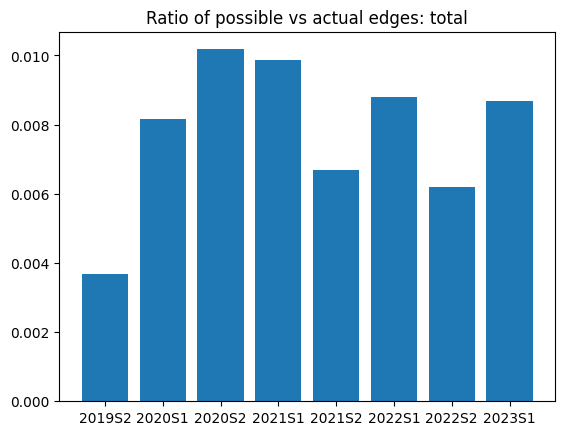

In [ ]:
plt.bar(labels, x["ratio_of_edges_total"])
plt.title("Ratio of possible vs actual edges: total")

Text(0.5, 1.0, 'Ratio of possible vs actual edges: EPP')

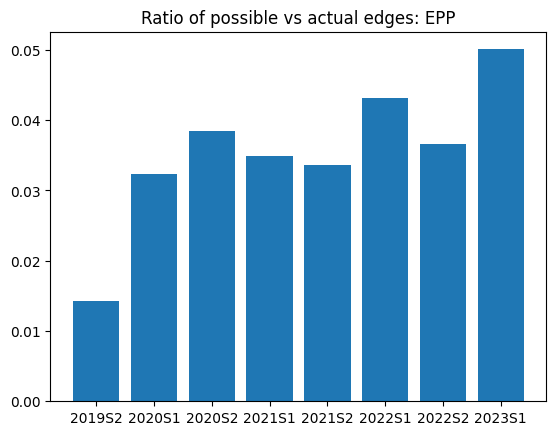

In [ ]:
plt.bar(labels, x["ratio_of_edges_epp"])
plt.title("Ratio of possible vs actual edges: EPP")

Text(0.5, 1.0, 'Ratio of possible vs actual edges: S&D')

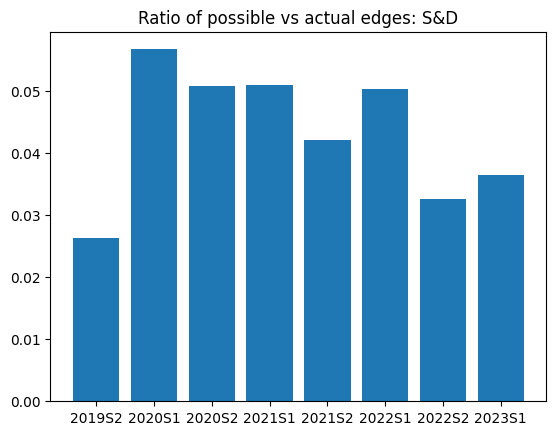

In [ ]:
plt.bar(labels, x["ratio_of_edges_s&d"])
plt.title("Ratio of possible vs actual edges: S&D")

Text(0.5, 1.0, 'Ratio of possible vs actual edges: RE')

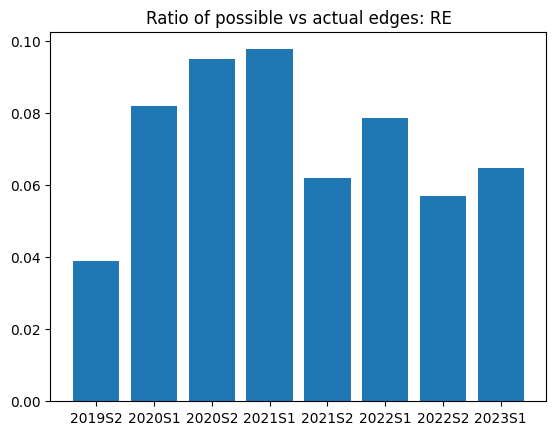

In [ ]:
plt.bar(labels, x["ratio_of_edges_re"])
plt.title("Ratio of possible vs actual edges: RE")

Text(0.5, 1.0, 'Ratio of possible vs actual edges: ECR')

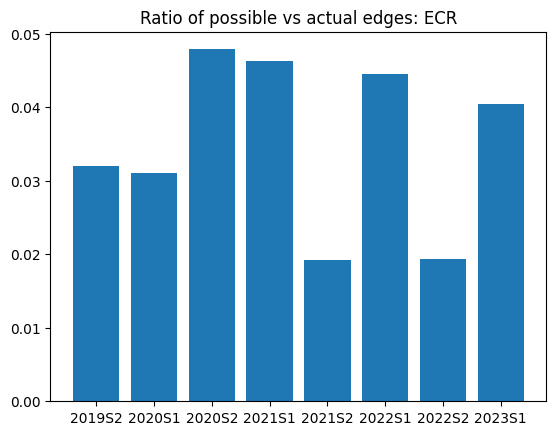

In [ ]:
plt.bar(labels, x["ratio_of_edges_ecr"])
plt.title("Ratio of possible vs actual edges: ECR")

Text(0.5, 1.0, 'Ratio of possible vs actual edges: ID')

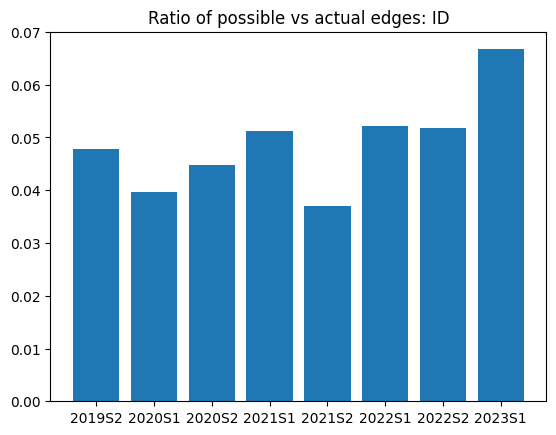

In [ ]:
plt.bar(labels, x["ratio_of_edges_id"])
plt.title("Ratio of possible vs actual edges: ID")

Text(0.5, 1.0, 'Ratio of possible vs actual edges: GUE/NGL')

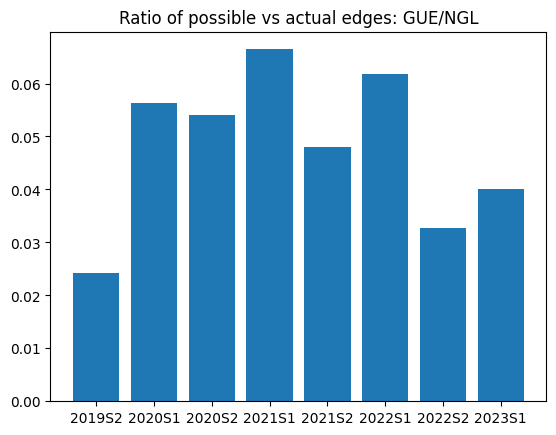

In [ ]:
plt.bar(labels, x["ratio_of_edges_gue/ngl"])
plt.title("Ratio of possible vs actual edges: GUE/NGL")

Text(0.5, 1.0, 'Ratio of possible vs actual edges: Greens/EFA')

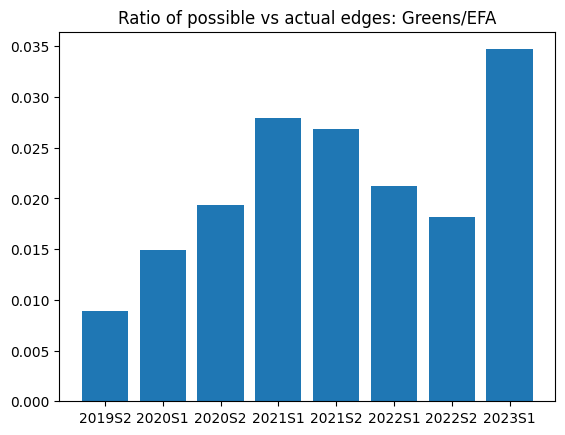

In [ ]:
plt.bar(labels, x["ratio_of_edges_greens/efa"])
plt.title("Ratio of possible vs actual edges: Greens/EFA")

## Központiságok

### Közelség központiság

Itt én azt látom, hogy kb. hullámzik, de inkább stagnál mindenhol, kivéve talán a szélsőjobboldali ID-nél.

Text(0.5, 1.0, 'Group closenesss: EPP')

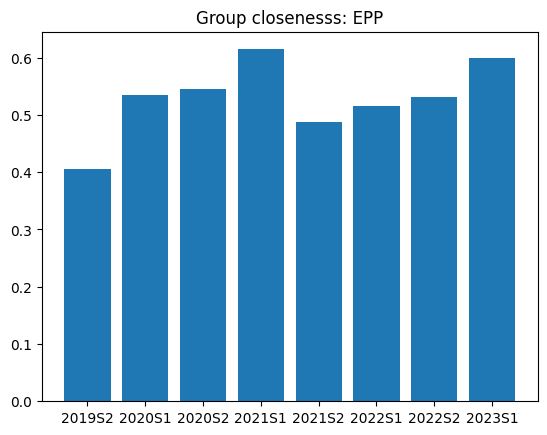

In [ ]:
plt.bar(labels, x["group_closeness_epp"])
plt.title("Group closenesss: EPP")

Text(0.5, 1.0, 'Group closenesss: S&D')

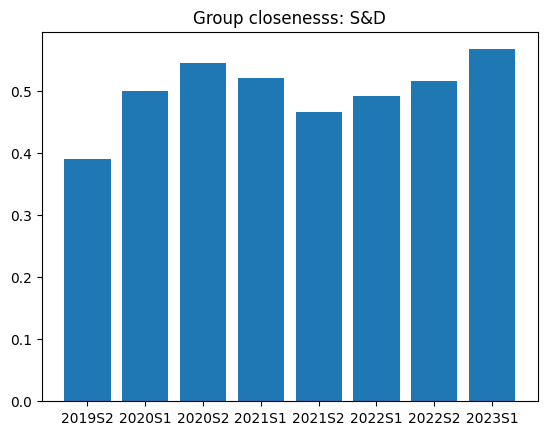

In [ ]:
plt.bar(labels, x["group_closeness_s&d"])
plt.title("Group closenesss: S&D")

Text(0.5, 1.0, 'Group closenesss: RE')

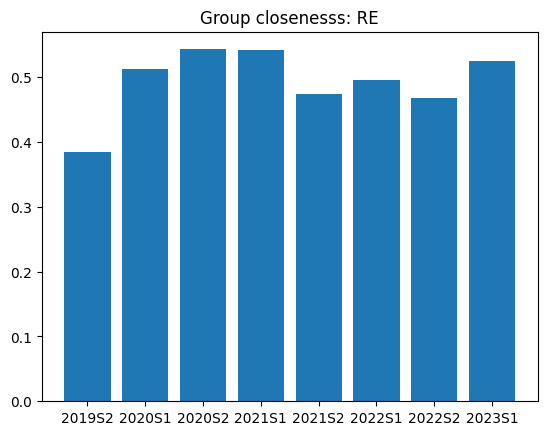

In [ ]:
plt.bar(labels, x["group_closeness_re"])
plt.title("Group closenesss: RE")

Text(0.5, 1.0, 'Group closenesss: ECR')

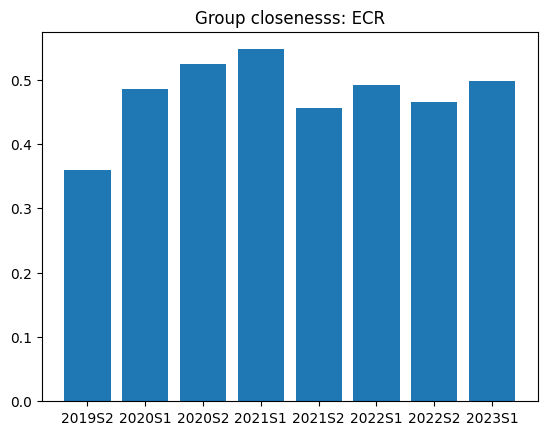

In [ ]:
plt.bar(labels, x["group_closeness_ecr"])
plt.title("Group closenesss: ECR")

Text(0.5, 1.0, 'Group closenesss: ID')

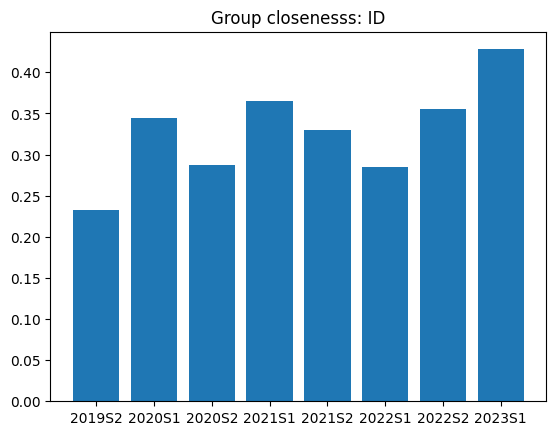

In [ ]:
plt.bar(labels, x["group_closeness_id"])
plt.title("Group closenesss: ID")

### Fokszám központiság

Arányaiban durva an növekedés az ID-nél!! De nézni kell a skálát is, mert az ID még mindig eléggé izolált!

Text(0.5, 1.0, 'Group degree: EPP')

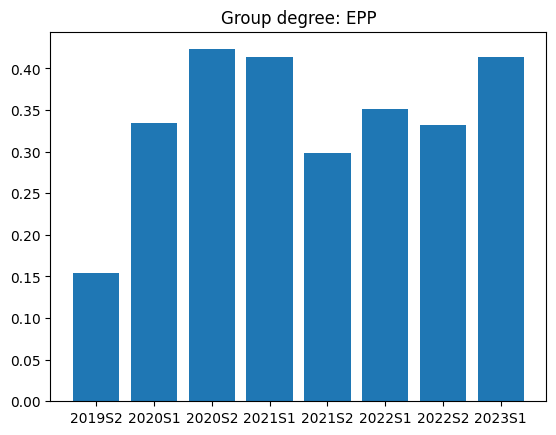

In [ ]:
plt.bar(labels, x["group_degree_epp"])
plt.title("Group degree: EPP")

Text(0.5, 1.0, 'Group degree: S&D')

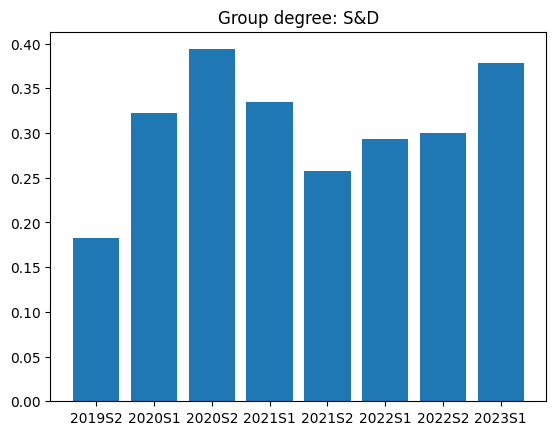

In [ ]:
plt.bar(labels, x["group_degree_s&d"])
plt.title("Group degree: S&D")

Text(0.5, 1.0, 'Group degree: RE')

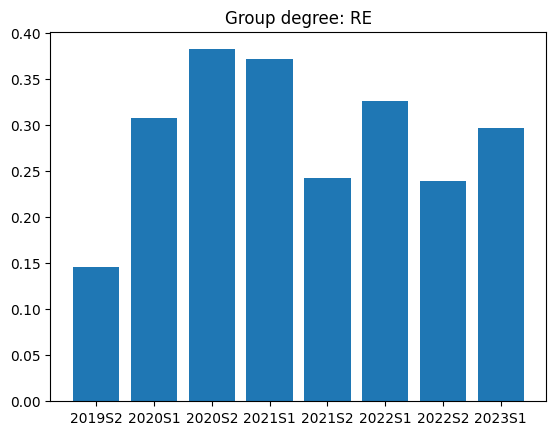

In [ ]:
plt.bar(labels, x["group_degree_re"])
plt.title("Group degree: RE")

Text(0.5, 1.0, 'Group degree: ECR')

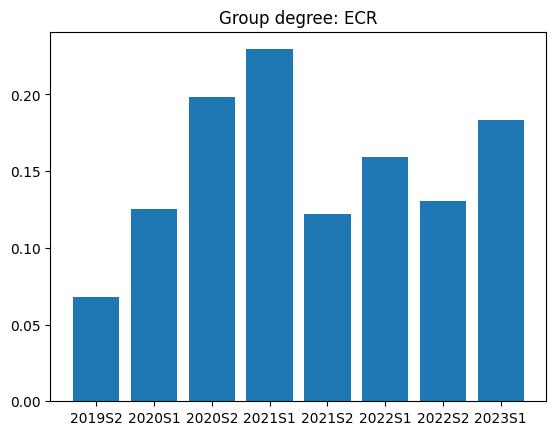

In [ ]:
plt.bar(labels, x["group_degree_ecr"])
plt.title("Group degree: ECR")

Text(0.5, 1.0, 'Group degree: ID')

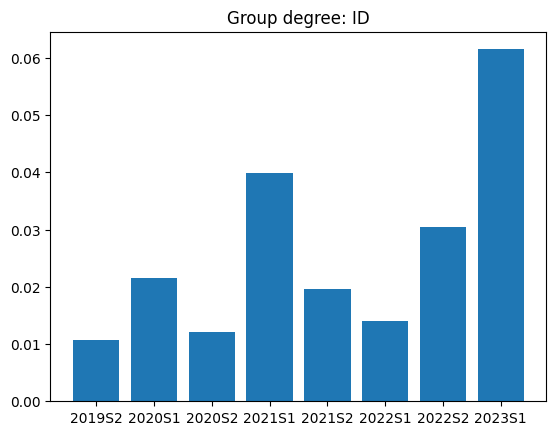

In [ ]:
plt.bar(labels, x["group_degree_id"])
plt.title("Group degree: ID")

### Közöttiség központiság

Az EPP lett a legfőbb közvetítő párt, pedig hagyományosan ez a liberális RE szokott lenni.

Text(0.5, 1.0, 'Group degree: EPP')

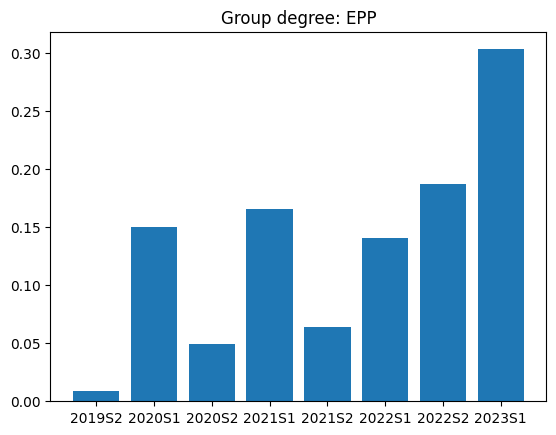

In [ ]:
plt.bar(labels, x["group_betweenness_epp"])
plt.title("Group degree: EPP")

Text(0.5, 1.0, 'Group degree: S&D')

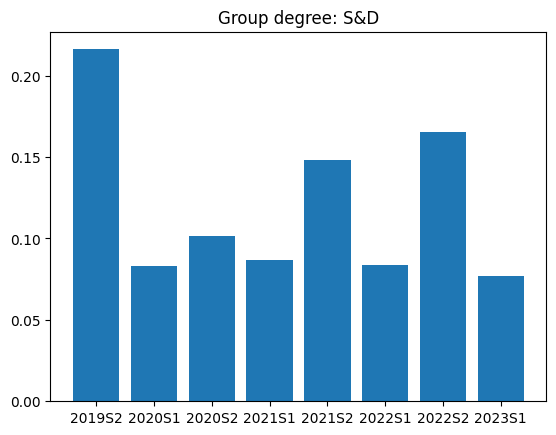

In [ ]:
plt.bar(labels, x["group_betweenness_s&d"])
plt.title("Group degree: S&D")

Text(0.5, 1.0, 'Group degree: RE')

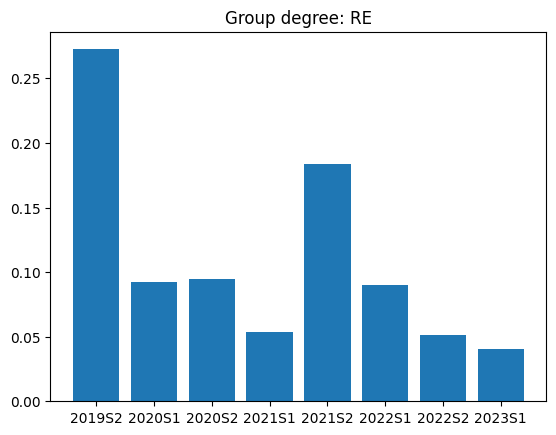

In [ ]:
plt.bar(labels, x["group_betweenness_re"])
plt.title("Group degree: RE")

Text(0.5, 1.0, 'Group degree: ECR')

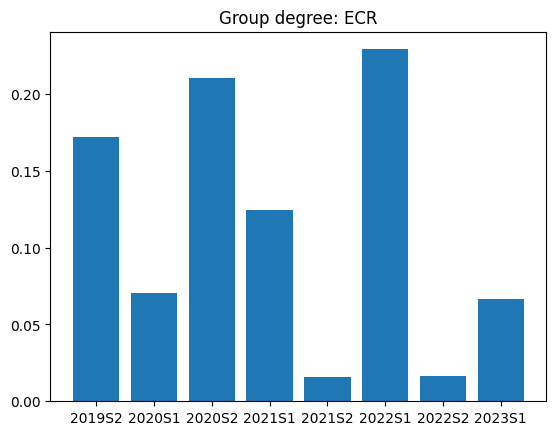

In [ ]:
plt.bar(labels, x["group_betweenness_ecr"])
plt.title("Group degree: ECR")

Text(0.5, 1.0, 'Group degree: ID')

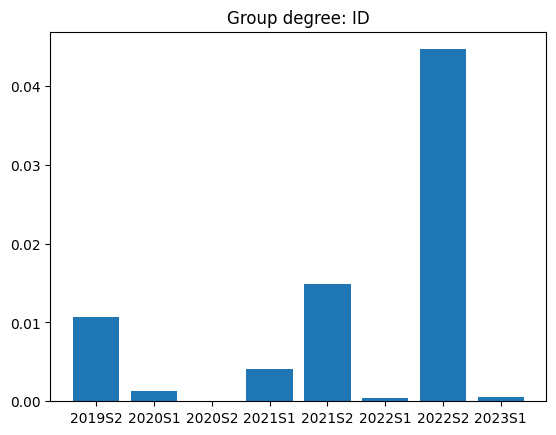

In [ ]:
plt.bar(labels, x["group_betweenness_id"])
plt.title("Group degree: ID")

## Konklúzió


1. A jobboldal koherensebb, mint eddig.
2. A szélsőjobb kevésbé elszigetelt, mint eddig, de nem mondhatjuk azt, hogy "bekerült a fősodorba"
3. A legfőbb közvetítői szerepet az EPP tölti be, pedig hagyományosan a liberálisok szokták. 
Ezt lehet úgy olvasni, hogy a liberális RE inkább a baloldal felé tolódott, és az EPP teremt kapcsolatot a szélsőjobbal.Tehát a közvetítői szerep a centrumból a mérsékelt jobboldalra tolódott.
<br>
Ezzel megteremtve a lehetőséget számukra az elszigeteltségből való kitöréshez. <be>
A közelgő választások tükrében, ismervén, hogy a fősodor pártjai a szélsőjobboldali pártok előretőrésétől tartanak, nagyon aktuális. <br>
Az eredmények nem zárják ki, hogy a választások eredményének tükrében egy jobboldali koalíció határozhatja meg az Unió jövőjét. <br>
Aggodalomra ad okot, hogy a szélsőjobb és a fősodorbeli jobboldal közötti szakadék csökkenni látszik így ha a választók erős üzenetet küldenek a mainstream számára a szélsőjobboldal meghatározó erővé válhat.